### WARNING

This notebook downloads the [Amazon Reviews Dataset](https://amazon-reviews-2023.github.io/data_loading/huggingface.html), which is quite large.  It was run on a machine with 128gb of RAM (though typically not using more than 50gb).

# Introduction

This notebook demonstrates how to use Pytorch, Shapley, and HDBSCAN to identify opportunity cohorts in arbitrary algorithms.  In it, we will make a simple (SVD) recommender and investigate what drives the largest errors in our recommendation system.

To fully appreciate the argument and context, I recommend reading the associated article [Labeling Opportunity Cohorts in Ad and Content Ranking Algorithms](https://medium.com/@dan.mallinger/labeling-opportunity-cohorts-in-ad-and-content-ranking-algorithms-2c2c0159c955).

## Settings

In [1]:
device = "cuda"
random_seed = 42

## Analysis imports

In [2]:
import copy
import datasets
import hdbscan
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import scipy
import shap
import string
import surprise
import textstat
import torch
import torchview
import wordcloud

from collections import defaultdict
from IPython.display import display, HTML, clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm.notebook import tqdm

## Helper functions and their imports

In [3]:
import hashlib
import IPython
import IPython.core.magic

def string_hash(string):
    """Consistent string hashing"""
    return int.from_bytes(hashlib.sha256(string.encode("utf-8")).digest())

@IPython.core.magic.magics_class
class CustomMagics(IPython.core.magic.Magics):
    """Defines the Jupyter magic %alert that will speak any phrase.

    Usage:
    %alert Done training model.
    """
    @IPython.core.magic.line_magic
    def alert(self, line):
        display(HTML(f"""
                <script id="custom_ipython_utterance">
                    var msg = new SpeechSynthesisUtterance();
                    msg.text = "{line}";
                    window.speechSynthesis.speak(msg);
                </script>
                <script>
                    // remove the prior utterance to prevent audio on page refresh
                    var e = document.getElementById('custom_ipython_utterance')
                    if(e) {{
                        e.remove()
                    }}
                </script>
             """))

ipython = IPython.get_ipython()
ipython.register_magics(CustomMagics)


class MSEPlot:
    """Ugly code! Dynamically updates plots of MSE so that one can visualize 
    error in real-time as a model trains.
    """
    def __init__(self):
        plt.ion()
        self.fig, self.ax = plt.subplots(1, 1)
        self.is_flushed = False

    def update(self, train_mse, validation_mse, title="", include_mse=True, epoch=None, batch=None, max_batches=None):
        if len(title) > 0:
            title = f"{title}\n"

        if epoch is not None and batch is not None:
            if max_batches is not None:
                title = f"{title}\nEpoch: {epoch}, {batch/max_batches*100:.0f}%"
            else:
                title = f"{title}\nEpoch: {epoch}, Batch: {batch}"
        elif epoch is not None:
            title = f"{title}\nEpoch: {epoch}"

        if include_mse and len(train_mse) > 0:
            title = f"{title}\nTrain: {train_mse[-1]:.3f}, Validation: {validation_mse[-1]:.3f}"
        
        self.ax.clear()
        self.ax.plot(train_mse)
        self.ax.plot(validation_mse)
        self.ax.legend(["Training", "Validation"], loc="upper right")
        if len(title) > 0:
            self.ax.set_title(title, fontsize=10)
        display(self.fig)
        clear_output(wait=True)
        self.is_flushed = False

    def flush(self):
        plt.ioff()
        plt.show()
        self.is_flushed = True
    
    def __del__(self):
        if not self.is_flushed:
            self.flush()

# Data Loading

We will investigate the Amazon 2023 review data, specificially the book reviews.

## Load the books review dataset

In [4]:
# load data
infos = datasets.get_dataset_infos("McAuley-Lab/Amazon-Reviews-2023")

# generate training/test splits for our recommendation engine
review_data = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Books", split="full", trust_remote_code=True)
book_metadata = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Books", split="full", trust_remote_code=True)
recsys_train_df = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", "5core_last_out_Books", split="train", trust_remote_code=True).to_pandas()
recsys_test_df = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", "5core_last_out_Books", split="test", trust_remote_code=True).to_pandas()

Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

## Create Grade-Level Dataset

We use the Flesch-Kincaid method to define the grade level of each user based on the text of their review.

In [5]:
valid_users = set(pd.concat([recsys_train_df, recsys_test_df])["user_id"].unique())
valid_books = set(recsys_train_df["parent_asin"].unique())
users_text = defaultdict(lambda: "")  # will store all book categories reviewed by this user
for row in review_data:
    if row["user_id"] in valid_users:
        users_text[row["user_id"]] += f"""{row["text"]}. """

# grade level and fog index for each user by row
users_textscore_df = pd.DataFrame([{"user_id": user_id,
                                    "grade_level": textstat.flesch_kincaid_grade(text),
                                    "fog_index": textstat.gunning_fog(text)} for user_id, text in users_text.items()])

## Create User Interest (Book Category) Dataset

This cell produces a sparse dataset flagging what categories of books (from roughly 1,100) this user read. Note that the dataset includes categories from both train and test data, which is technically a problem. However, this is a demonstrative notebook and small biases like this are ignored.

In [6]:
# dictionaries of titles and categories by book asin
book_titles = {}
book_categories = defaultdict(lambda: set([]))
for row in book_metadata:
    if row["parent_asin"] in valid_books:
        book_titles[row["parent_asin"]] = row["title"]
        book_categories[row["parent_asin"]].update(row["categories"])

# all books reviewed by this user
users_books = defaultdict(lambda: set([]))
# dictionary of book categories reviewed by user ID
# format: dict[user_id][category] = count
users_book_categories_count = defaultdict(lambda: defaultdict(lambda: 0))

for row in review_data:
    if row["user_id"] in valid_users and row["parent_asin"] in valid_books:
        users_books[row["user_id"]].add(book_titles[row["parent_asin"]])

    if row["user_id"] in valid_users:
        for category in book_categories[row["parent_asin"]]:
            users_book_categories_count[row["user_id"]][category] += 1

valid_book_categories = set([category for category_counts in users_book_categories_count.values() for category in category_counts.keys()])
default_book_categories = {category: 0 for category in valid_book_categories}

# this is the dataset we will use for multiple analyses:
# sparse dataframe of book categories reviewed per user row.
#
# option a: 0 v 1 dichotomous indicator of reviewing a book in category C
users_book_categories_df = pd.DataFrame([default_book_categories | {category: 1 for category, count in users_book_categories_count[user_id].items()} | {"user_id": user_id} for user_id in valid_users])
# option b: weighted by # books
# users_book_categories_df = pd.DataFrame([default_book_categories | {category: count / np.sum(list(users_book_categories_count[user_id].values())) for category, count in users_book_categories_count[user_id].items()} | {"user_id": user_id} for user_id in valid_users])

# Ranking Model Creation

Simple SVD recommender over the Amazon book reviews which is used to product `prediction_df`, one real value and one prediction per user in a test group.

In [7]:
# lightweight singular value decomposition-based recommendation engine
recommender = surprise.SVD()
reader = surprise.Reader(rating_scale=(1, 5))
recsys_train_data = surprise.Dataset.load_from_df(recsys_train_df[["user_id", "parent_asin", "rating"]], reader).build_full_trainset()
recommender.fit(recsys_train_data)

# the prediction dataframe has a row per prediction and its outcome
# because of the nature of the train/test split, there is one row per user in test
prediction_df = pd.DataFrame(recommender.test([(row["user_id"], row["parent_asin"], row["rating"]) for _, row in recsys_test_df.iterrows()])).rename(columns={"uid": "user_id", "iid": "parent_asin", "r_ui": "rating", "est": "prediction"})
prediction_df["rating"] = prediction_df["rating"].astype(float)
prediction_df["delta"] = prediction_df["prediction"] - prediction_df["rating"]
prediction_df["delta_zscore"] = scipy.stats.zscore(prediction_df["delta"])

## Dataset Finalization and Cleanup

`interest_model_df` is the final dataset we will use for all analysis (recommendations, grade level, interests, etc.).

In [8]:
users_books_df = pd.DataFrame(users_books.items(), columns=["user_id", "books"])
interest_model_df = users_book_categories_df.merge(users_books_df, how="inner", on="user_id").merge(users_textscore_df, how="inner", on="user_id").merge(prediction_df, how="inner", on="user_id")
has_category_mask = ((0 < interest_model_df[list(valid_book_categories)].sum(axis=1)) & (interest_model_df[list(valid_book_categories)].sum(axis=1) < np.inf)).to_numpy()
interest_model_df = interest_model_df.iloc[has_category_mask]

# free up memory for clustering
del review_data, book_metadata
del recommender
del recsys_train_df, recsys_test_df, recsys_train_data
del users_text
del book_titles, book_categories
del users_books, users_book_categories_count, default_book_categories
del users_book_categories_df, users_books_df, users_textscore_df, prediction_df

# Demonstrating Feature Miscalibration

## Miscalibration due to (Comment Text) Grade Level

This cell demonstrations how to proportionally size opportunities according to the miscalibration of our algorithm based on the feature in question. Here, we see that grade-level appears to matter to our model performance.

Additional notes of items out of scope of demonstration:

* `rating` and `delta` are rather correlated, we would look into this normally as this could bias our results.
* A cursory review suggests that the extremes of grade-level are biased by users with poorly formatted or repeatitive text in their reviews.

Correlation Table:


,rating,delta,delta_zscore,grade_level,fog_index
rating,1.000000,-0.930101,-0.930101,-0.096126,-0.114249
delta,-0.930101,1.000000,1.000000,0.050819,0.062018
delta_zscore,-0.930101,1.000000,1.000000,0.050819,0.062018
grade_level,-0.096126,0.050819,0.050819,1.000000,0.899429
fog_index,-0.114249,0.062018,0.062018,0.899429,1.000000


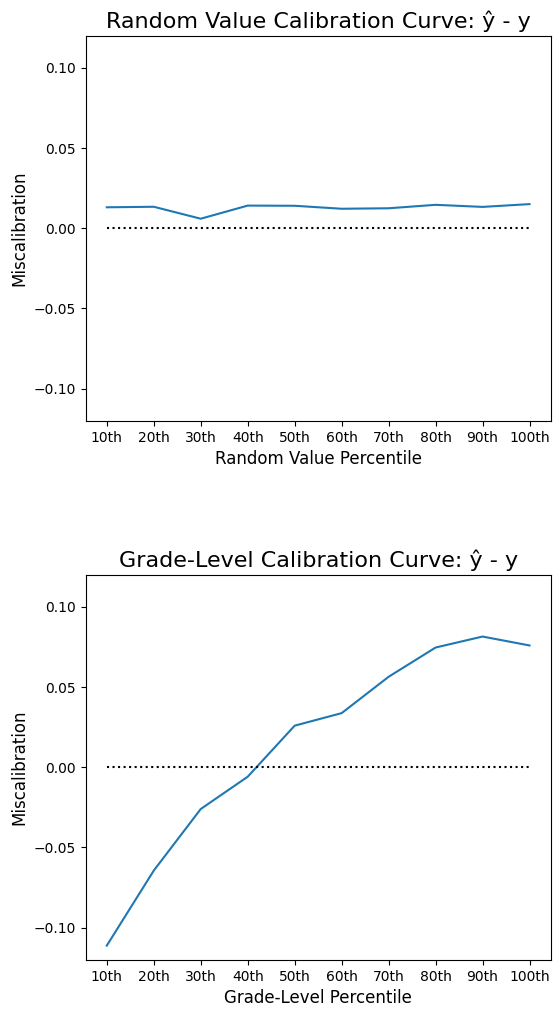

In [9]:
print("Correlation Table:")
display(interest_model_df[["rating", "delta", "delta_zscore", "grade_level", "fog_index"]].corr())

# this chart renders two calibration analyses, one random and one based on grade level
# what we see is that grade-level appears to matter in our predictions!
fig, axes = plt.subplots(2, 1, figsize=(6, 12))
fig.subplots_adjust(hspace=0.4)

df = interest_model_df.copy()
df["grade_level_decile"] = pd.qcut(np.random.rand(len(df)), 10, labels=False)
df = df.groupby(by=["grade_level_decile"]).agg({"delta": "mean"})

axes[0].plot(df["delta"])
axes[0].hlines(0, 0, 9, color="black", linestyle=":")
axes[0].set_title("Random Value Calibration Curve: ŷ - y", fontsize=16)
axes[0].set_xlabel("Random Value Percentile", fontsize=12)
axes[0].set_xticks(df.index)
axes[0].set_xticklabels([f"""{i*10+10}th""" for i in range(10)])
axes[0].set_ylabel("Miscalibration", fontsize=12)
axes[0].set_ylim((-0.12, 0.12))

df = interest_model_df.copy()
df["grade_level_decile"] = pd.qcut(df["grade_level"], 10, labels=False)
df = df.groupby(by=["grade_level_decile"]).agg({"delta": "mean"})

axes[1].plot(df["delta"])
axes[1].hlines(0, 0, 9, color="black", linestyle=":")
axes[1].set_title("Grade-Level Calibration Curve: ŷ - y", fontsize=16)
axes[1].set_xlabel("Grade-Level Percentile", fontsize=12)
axes[1].set_xticks(df.index)
axes[1].set_xticklabels([f"""{i*10+10}th""" for i in range(10)])
axes[1].set_ylabel("Miscalibration", fontsize=12)
axes[1].set_ylim((-0.12, 0.12))
fig.show()

# Algorithm Error Model

Here we train our model of book recommender error, ŷ - y. Note that this model is rather odd: we have deliberately selected a situation where the data are:
1. Of high dimensionality (~1,100 interests)
1. Sparse
1. Only weakly related to our outcome variable

#3 is the primary challenge and occurs for two reasons:
1. The methodology focuses on finding indicators of error. If these were strong predictors, we probably would have included them in the recommendation algorithm already. Accordingly, we often are looking at low performing models.
1. This is a toy example with particularly weak indicators

Ultimately, this is a very messy area to be modeling but the methodology requires that we handle it well. Some of the modeling choices may reflect this atypical scenario.

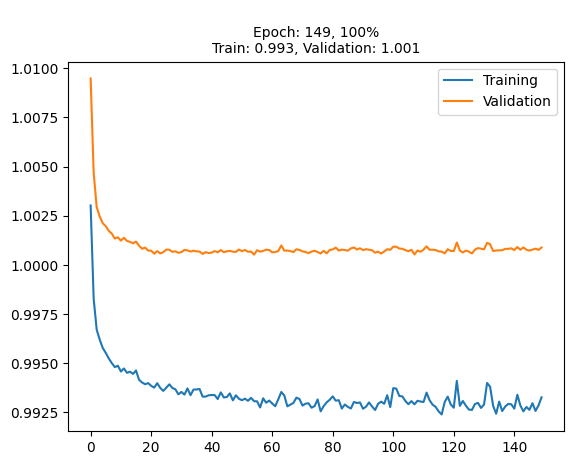

Overall y~y_pred correlation
Train:
SignificanceResult(statistic=0.035388595253204286, pvalue=3.809087344440994e-153)
Validation:
SignificanceResult(statistic=0.015644394471732652, pvalue=1.884981950487336e-07)


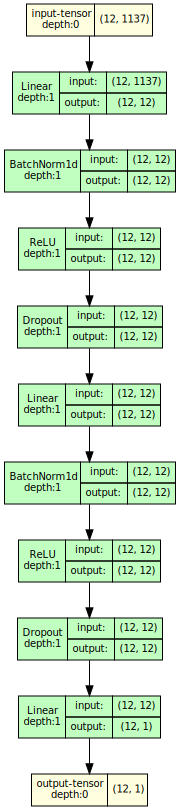

CPU times: user 2h 14min 8s, sys: 8min 5s, total: 2h 22min 13s
Wall time: 2h 15min 35s


In [10]:
%%time

# same samples every time
np.random.seed(random_seed)

sample_mask = pd.qcut(np.random.rand(len(interest_model_df)), 7, labels=False)
interest_model_train_df = interest_model_df.iloc[sample_mask >= 2]
interest_model_validation_df = interest_model_df.iloc[sample_mask == 0]
interest_model_test_df = interest_model_df.iloc[sample_mask == 1]

# CUDA test and train datasets
X_train = torch.tensor(interest_model_train_df[list(valid_book_categories)].to_numpy(), device=device, dtype=torch.float32)
y_train = torch.tensor(interest_model_train_df["delta_zscore"].to_numpy(), device=device, dtype=torch.float32)
X_validation = torch.tensor(interest_model_validation_df[list(valid_book_categories)].to_numpy(), device=device, dtype=torch.float32)
y_validation = torch.tensor(interest_model_validation_df["delta_zscore"].to_numpy(), device=device, dtype=torch.float32)
X_test = torch.tensor(interest_model_test_df[list(valid_book_categories)].to_numpy(), device=device, dtype=torch.float32)
y_test = torch.tensor(interest_model_test_df["delta_zscore"].to_numpy(), device=device, dtype=torch.float32)


# building a neural network to predict algorithm error.
hidden_layer_width = 12
interest_model = nn.Sequential(
                     nn.Linear(in_features=X_train.shape[1], out_features=hidden_layer_width),
                     nn.BatchNorm1d(hidden_layer_width),
                     nn.ReLU(),
                     nn.Dropout(p=0.3),
                     nn.Linear(in_features=hidden_layer_width, out_features=hidden_layer_width),
                     nn.BatchNorm1d(hidden_layer_width),
                     nn.ReLU(),
                     nn.Dropout(p=0.1),
                     nn.Linear(hidden_layer_width, 1)
                 ).to(device=device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(interest_model.parameters(), lr=0.00001, weight_decay=0.0075)

n_epochs = 150
batch_size = 12
# store (and plot) the MSE by epoch for train and test
mse_history_train, mse_history_validation = [], []
# plot the change in MSE over time
mse_plot = MSEPlot()

for epoch in range(n_epochs):
    interest_model.train()
    indices = torch.randperm(len(X_train))
    batches = len(X_train) // batch_size
    for batch in range(batches):
        # random batch.  todo: use a dataloader here
        slice_ = indices[batch*batch_size:batch*batch_size+batch_size]
        # occassional updates about batch progress
        if batch % 2500 == 0:
            mse_plot.update(mse_history_train, mse_history_validation, epoch=epoch, batch=batch, max_batches=batches)
        
        X_batch = X_train[slice_]
        y_batch = y_train[slice_]
        y_pred = interest_model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate MSE per epoch
    interest_model.eval()
    with torch.inference_mode():
        y_pred = interest_model(X_train).squeeze()
        train_mse = float(loss_fn(y_pred, y_train))
        mse_history_train.append(train_mse)
        y_pred = interest_model(X_validation).squeeze()
        validation_mse = float(loss_fn(y_pred, y_validation))
        mse_history_validation.append(validation_mse)

    # update graph
    mse_plot.update(mse_history_train, mse_history_validation, epoch=epoch, batch=batch, max_batches=batches)

# ensure graph renders above additional information
mse_plot.flush()

# prediction datasets
interest_model.eval()
with torch.inference_mode():
    y_train_pred = interest_model(X_train).squeeze()
    y_validation_pred = interest_model(X_validation).squeeze()
    y_test_pred = interest_model(X_test).squeeze()


# we expect the overall correlation to be weak- after all, if we can predict ŷ - y easily, then the model
# is missing something super obvious in the data.
print("Overall y~y_pred correlation")
print("Train:")
print(scipy.stats.spearmanr(y_train.cpu().numpy(), y_train_pred.cpu().numpy()))
print("Validation:")
print(scipy.stats.spearmanr(y_validation.cpu().numpy(), y_validation_pred.cpu().numpy()))

# render model architecture
interest_model_graph = torchview.draw_graph(interest_model, input_size=(batch_size, X_validation.shape[1]))
display(interest_model_graph.visual_graph)

# Calculating SHAP

We use the DeepExplainer to generate SHAP values as it is much faster than the KernelExplainer on torch models.

In [11]:
%%time

# Shapley background data needs to be smaller for our code to run quickly, so we use the kmeans
# method to identify representative background data.
X_train_summary = shap.kmeans(X_train.cpu().detach().numpy(), int(X_train.shape[1] ** 0.5))

# get shapley values
interest_model.eval() # disable dropout layers
explainer = shap.DeepExplainer(interest_model.to(device=device), torch.tensor(X_train_summary.data, device=device, dtype=torch.float32, requires_grad=False))
shap_validation = explainer.shap_values(X_validation).squeeze()
shap_test = explainer.shap_values(X_test).squeeze()

CPU times: user 2h 51min 16s, sys: 4h 10min 5s, total: 7h 1min 22s
Wall time: 32min 39s


# Clustering SHAP

Users with similar SHAP values are presumed to have similar algorithm experiences (e.g. similar book interests with similar biases in recommendations).  If we find greater algorithm error in some of these cohorts, then explaining the reason for cohort error will become a key plan for improving user experience.

In [12]:
%%time

clusterer_validation = hdbscan.HDBSCAN(min_cluster_size=int(shap_validation.shape[0]*0.01), prediction_data=True)
clusters_validation = clusterer_validation.fit(shap_validation).labels_
clusters_test = hdbscan.approximate_predict(clusterer_validation, shap_test)

/home/mallinger/venv/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mallinger/venv/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 8h 22min 3s, sys: 10min 48s, total: 8h 32min 52s
Wall time: 8h 19min 9s


# Analyzing SHAP Clusters

Here we find clusters of SHAP values (i.e. book recommendation experience) and inspect their defining characteristics.

In [41]:
%%time

def format_cluster_df(interest_df, clusters):
    """Helper function takes the interest DataFrame and our new clusters.
    returns a new summary DataFrame over these clusters."""
    def clean_group_names(row):
        if row["cluster_id"] == -1:
            return "Noise"
        return string.ascii_uppercase[row["cluster_id"]]

    df = interest_df.copy()
    df["count"] = 1
    df["cluster_id"] = clusters
    df["interests"] = df.apply(lambda row: [category for category in valid_book_categories if row[category] > 0], axis=1)
    df_agg = df.groupby(by=["cluster_id"]).agg({"count": "count",
                                                "delta_zscore": "mean",
                                                "interests": lambda categories_list: [category for categories in categories_list for category in categories],
                                                "books": lambda books_list: [book for books in books_list for book in books]
                                               }).sort_values(by=["count"], ascending=False).reset_index()
    df_agg["cluster_name"] = df_agg.apply(clean_group_names, axis=1)
    return df, df_agg[["cluster_id", "cluster_name", "count", "delta_zscore", "interests", "books"]]


def list_clusters_to_tfidf(df, column):
    """Expects a DataFrame with one row per cluster and a column for book interests
    and returns a DataFrame with one row per book, columns for groups, and tfidf scores.
    """
    tfidf = TfidfVectorizer(analyzer=lambda x: x, sublinear_tf=True, max_df=0.8)
    tfidf_matrix = tfidf.fit_transform(df[column])
    return pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out()).T.rename(columns=dict(zip(df.index, df["cluster_name"])))


# DataFrame summary of clusters
clusters_raw_validation_df, clusters_validation_df = format_cluster_df(interest_model_validation_df, clusters_validation)
clusters_raw_test_df, clusters_test_df = format_cluster_df(interest_model_test_df, clusters_test[0])
# TFIDF data frames
interest_tfidf_validation_df = list_clusters_to_tfidf(clusters_validation_df, "interests")
interest_tfidf_test_df = list_clusters_to_tfidf(clusters_test_df, "interests")
book_tfidf_validation_df = list_clusters_to_tfidf(clusters_validation_df, "books")
book_tfidf_test_df = list_clusters_to_tfidf(clusters_test_df, "books")

CPU times: user 2min 19s, sys: 737 ms, total: 2min 19s
Wall time: 2min 19s


As a sanity check, we confirm that the validation and test clusters appear similar and that Noise has low TF-IDF values. They do!

In [42]:
print("Validation:")
display(clusters_validation_df)

print("Test:")
display(clusters_test_df)

print("Validation:")
display(interest_tfidf_validation_df.sort_values(by=["Noise"], ascending=False)[0:10])

print("Test:")
display(interest_tfidf_test_df.sort_values(by=["Noise"], ascending=False)[0:10])

print("Validation:")
display(book_tfidf_validation_df.sort_values(by=["Noise"], ascending=False)[0:10])

print("Test:")
display(book_tfidf_test_df.sort_values(by=["Noise"], ascending=False)[0:10])

Validation:


,cluster_id,cluster_name,count,delta_zscore,interests,books
0,-1,Noise,101510,-0.001203,"[Genre Fiction, Leaders & Notable People, Euro...",[Hello Goodbye Hello: A Circle of 101 Remarkab...
1,3,D,3523,0.009899,"[Genre Fiction, Thrillers & Suspense, Mystery,...",[Skeleton Man (A Leaphorn and Chee Novel Book ...
2,1,B,2905,-0.086189,"[Thrillers & Suspense, Mystery, Thriller & Sus...",[The Enemy Inside: A Paul Madriani Novel (Paul...
3,2,C,1787,-0.018988,"[Mystery, Genre Fiction, Thrillers & Suspense,...","[To Sir, With Love, Those Who Save Us, Uneasy ..."
4,0,A,1185,-0.030342,"[Mystery, Thrillers & Suspense, Mystery, Thril...","[Fool Me Once, Suspect, The Fall: A Novel (Dis..."


Test:


,cluster_id,cluster_name,count,delta_zscore,interests,books
0,-1,Noise,101394,0.006488,"[Mystery, Action & Adventure, Thrillers & Susp...","[Identity Thief, The Mountain (Ryan Decker Boo..."
1,3,D,3573,-0.017604,"[Genre Fiction, Thrillers & Suspense, Mystery,...",[Final Betrayal: An absolutely gripping crime ...
2,1,B,2875,-0.064077,"[Thrillers & Suspense, Mystery, Thriller & Sus...","[Private Sector, The Body Market: A Leine Bass..."
3,2,C,1804,-0.032310,"[Mystery, Genre Fiction, Thrillers & Suspense,...","[The Fix (Memory Man Series, 3), Line of Visio..."
4,0,A,1263,-0.067551,"[Mystery, Thrillers & Suspense, Mystery, Thril...",[THE LADY VANISHED a gripping detective myster...


Validation:


,Noise,D,B,C,A
Children's Books,0.072696,0.0,0.0,0.0,0.0
Biographies & Memoirs,0.069164,0.0,0.0,0.0,0.0
Growing Up & Facts of Life,0.068967,0.0,0.0,0.0,0.0
"Crafts, Hobbies & Home",0.068935,0.0,0.0,0.0,0.0
Arts & Photography,0.068720,0.0,0.0,0.0,0.0
Science Fiction & Fantasy,0.068000,0.0,0.0,0.0,0.0
History,0.067941,0.0,0.0,0.0,0.0
Politics & Social Sciences,0.067234,0.0,0.0,0.0,0.0
Teen & Young Adult,0.067231,0.0,0.0,0.0,0.0
"Cookbooks, Food & Wine",0.067008,0.0,0.0,0.0,0.0


Test:


,Noise,D,B,C,A
Children's Books,0.072380,0.0,0.0,0.0,0.0
Biographies & Memoirs,0.068890,0.0,0.0,0.0,0.0
Growing Up & Facts of Life,0.068684,0.0,0.0,0.0,0.0
"Crafts, Hobbies & Home",0.068633,0.0,0.0,0.0,0.0
Arts & Photography,0.068483,0.0,0.0,0.0,0.0
Science Fiction & Fantasy,0.067724,0.0,0.0,0.0,0.0
History,0.067598,0.0,0.0,0.0,0.0
Politics & Social Sciences,0.067004,0.0,0.0,0.0,0.0
Teen & Young Adult,0.066913,0.0,0.0,0.0,0.0
"Cookbooks, Food & Wine",0.066726,0.0,0.0,0.0,0.0


Validation:


,Noise,D,B,C,A
Educated: A Memoir,0.006696,0.0,0.0,0.0,0.0
"The Atlantis Gene: A Thriller (The Origin Mystery, Book 1)",0.006560,0.0,0.0,0.0,0.0
The Storied Life of A. J. Fikry: A Novel,0.006268,0.0,0.0,0.0,0.0
The Book Thief,0.006173,0.0,0.0,0.0,0.0
Proof of Heaven: A Neurosurgeon's Journey into the Afterlife,0.006004,0.0,0.0,0.0,0.0
The Life-Changing Magic of Tidying Up: The Japanese Art of Decluttering and Organizing,0.005987,0.0,0.0,0.0,0.0
First 100 Words: A Padded Board Book,0.005920,0.0,0.0,0.0,0.0
Love You Forever,0.005878,0.0,0.0,0.0,0.0
Becoming,0.005862,0.0,0.0,0.0,0.0
Giraffes Can't Dance (Board Book),0.005845,0.0,0.0,0.0,0.0


Test:


,Noise,D,B,C,A
Educated: A Memoir,0.006665,0.0,0.0,0.0,0.0
"The Atlantis Gene: A Thriller (The Origin Mystery, Book 1)",0.006562,0.0,0.0,0.0,0.0
The Storied Life of A. J. Fikry: A Novel,0.006268,0.0,0.0,0.0,0.0
First 100 Words: A Padded Board Book,0.006110,0.0,0.0,0.0,0.0
The Book Thief,0.006064,0.0,0.0,0.0,0.0
The Life-Changing Magic of Tidying Up: The Japanese Art of Decluttering and Organizing,0.006019,0.0,0.0,0.0,0.0
Becoming,0.006013,0.0,0.0,0.0,0.0
Love You Forever,0.005993,0.0,0.0,0.0,0.0
Proof of Heaven: A Neurosurgeon's Journey into the Afterlife,0.005981,0.0,0.0,0.0,0.0
The Wonky Donkey,0.005905,0.0,0.0,0.0,0.0


Summary of Parents Cohort:

Interests:


,Noise,D,B,C,A
Mystery,0.044948,0.0,0.0,0.564391,0.935132
Private Investigators,0.021250,0.0,0.0,0.000000,0.234289
Traditional Detectives,0.021045,0.0,0.0,0.000000,0.138375
MIRA,0.015511,0.0,0.0,0.000000,0.138375
Harlequin Store,0.017115,0.0,0.0,0.000000,0.138375
Hard-Boiled,0.004181,0.0,0.0,0.066416,0.114864
#Booktok,0.013102,0.0,0.0,0.000000,0.000000
Nutrition,0.039831,0.0,0.0,0.000000,0.000000
Nursing,0.035118,0.0,0.0,0.000000,0.000000
Notebooks,0.006243,0.0,0.0,0.000000,0.000000


Books:


,Noise,D,B,C,A
Escape Clause (A Virgil Flowers Novel Book 9),0.003215,0.000000,0.000000,0.029791,0.059086
The Boat Man: A Mystery Suspense Thriller,0.003368,0.000000,0.000000,0.028371,0.051427
The Promise: An Elvis Cole and Joe Pike Novel,0.003030,0.000000,0.000000,0.023564,0.051047
Mr. Mercedes: A Novel (The Bill Hodges Trilogy Book 1),0.003941,0.000000,0.000000,0.037662,0.048932
Finders Keepers: A Novel (The Bill Hodges Trilogy Book 2),0.003618,0.000000,0.000000,0.035212,0.047965
Guardians of the Night (A Gideon and Sirius Novel Book 2),0.003373,0.000000,0.000000,0.030521,0.047450
Saving Grace (A Katie Connell Caribbean Mystery): A What Doesn't Kill You Mystery,0.003350,0.000000,0.000000,0.028048,0.046910
"The Silent Twin: A dark, gripping detective thriller (Detective Jennifer Knight Crime Thriller Series Book 3)",0.002655,0.000000,0.000000,0.022903,0.045749
She Can Tell,0.002941,0.000000,0.000000,0.024167,0.044459
Pretty Dead (Elise Sandburg Book 3),0.002836,0.000000,0.000000,0.026162,0.044459


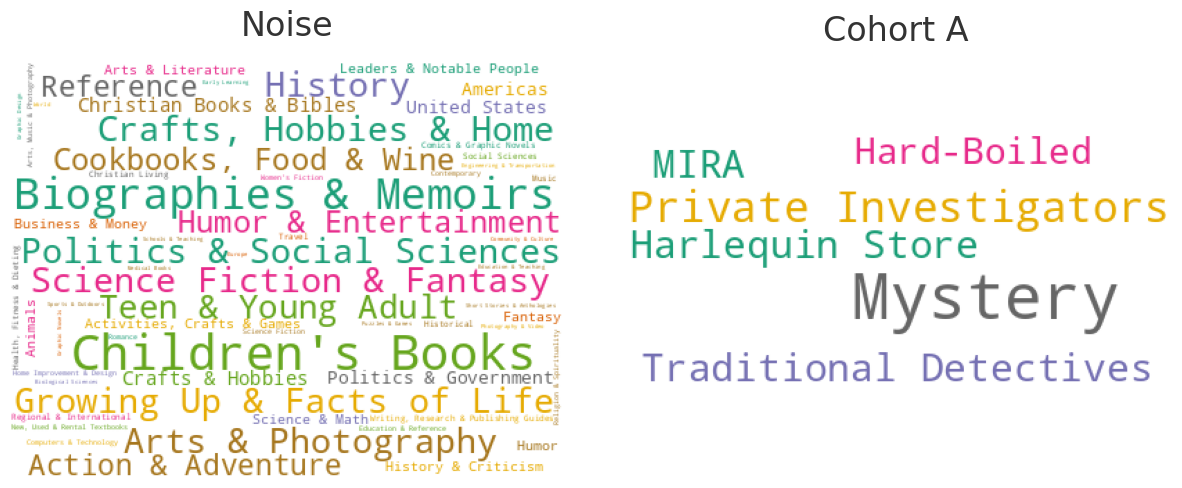

In [48]:
cohort = "A"

print("Interests:")
display(interest_tfidf_test_df.sort_values(by=[cohort], ascending=False)[0:10])

print("Books:")
display(book_tfidf_test_df.sort_values(by=[cohort], ascending=False)[0:50])

frequencies_cohort = dict(interest_tfidf_test_df[interest_tfidf_test_df[cohort] > 0][cohort] / interest_tfidf_test_df[interest_tfidf_test_df[cohort] > 0][cohort].sum())
frequencies_noise = dict(interest_tfidf_test_df[interest_tfidf_test_df["Noise"] > 0]["Noise"] / interest_tfidf_test_df[interest_tfidf_test_df["Noise"] > 0]["Noise"].sum())
cloud = wordcloud.WordCloud(height=300, relative_scaling=1.0, max_words=500, background_color="white", colormap="Dark2").generate_from_frequencies(frequencies_noise)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.1)
axes[0].set_title("Noise", fontsize=24, pad=20, color="#333333")
axes[0].imshow(cloud)
axes[0].axis("off")

cloud = wordcloud.WordCloud(relative_scaling=0.2, max_words=500, background_color="white", colormap="Dark2").generate_from_frequencies(frequencies_cohort)
axes[1].set_title("Cohort A", fontsize=24, pad=66, color="#333333")
axes[1].imshow(cloud)
axes[1].axis("off")

plt.show()

In [44]:
%alert done with TFIDF